# Import Libraries and DataFrame

In [1]:
!pip install prophet

import os
import datetime
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
from prophet import Prophet
from sklearn.metrics import mean_absolute_error
import seaborn as sns
from sklearn.linear_model import LinearRegression


In [3]:
drive.mount('/content/drive')
data_path = '/content/drive/Shared drives/Gestió de Projectes/3. Executing/Data/'
filename = 'processed_data.csv'
sep = ","
encoding = "utf-8"

# Set pandas to show all columns
pd.set_option('display.max_columns', None)

# Load and concatenate all CSV files into one DataFrame
df = pd.read_csv(data_path + filename, sep=sep, encoding=encoding)

def str_to_datetime(s): # used to convert the date into an index
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

Mounted at /content/drive


# Data Preparation for Prophet

In [4]:
# Convert day column to datetime
df['day'] = pd.to_datetime(df['day'])
# Define unique journeys
unique_journeys = df[['provincia_origen_name', 'provincia_destino_name']].drop_duplicates()

In [5]:
def prepare_data_for_prophet(journey_df):
    """Prepares the data for Prophet model"""
    journey_df = journey_df.sort_values('day')
    prophet_df = journey_df[['day', 'viajes']].rename(columns={'day': 'ds', 'viajes': 'y'})
    return prophet_df

models = []

for _, row in df[['provincia_origen_name', 'provincia_destino_name']].drop_duplicates().iterrows():
    journey_key = f"{row['provincia_origen_name']}_to_{row['provincia_destino_name']}"

    journey_df = df[(df['provincia_origen_name'] == row['provincia_origen_name']) &
                    (df['provincia_destino_name'] == row['provincia_destino_name'])]

    prophet_data = prepare_data_for_prophet(journey_df)

    prophet_data['ds'] = pd.to_datetime(prophet_data['ds'])

    model = Prophet(
        seasonality_mode='multiplicative',
        yearly_seasonality=True,
        weekly_seasonality=True,
        changepoint_prior_scale=0.25
    )

    model.fit(prophet_data)

    models.append((journey_key, model, prophet_data))

    future = model.make_future_dataframe(periods=1095)
    forecast = model.predict(future)

    forecast['ds'] = pd.to_datetime(forecast['ds'])

    y_true = prophet_data['y'].values
    y_pred = forecast['yhat'][:len(y_true)].values

    journey_results = {
        "journey_key": journey_key,
        "actual_data": prophet_data[['ds', 'y']],
        "predictions": forecast[['ds', 'yhat']],
        "forecast_for_3_years": forecast[['ds', 'yhat']].tail(1095)
    }

    models[-1] = (models[-1][0], models[-1][1], models[-1][2], journey_results)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphxq24efy/4hm4gdgz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphxq24efy/45emj6fv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61059', 'data', 'file=/tmp/tmphxq24efy/4hm4gdgz.json', 'init=/tmp/tmphxq24efy/45emj6fv.json', 'output', 'file=/tmp/tmphxq24efy/prophet_modelay0h56gj/prophet_model-20241201172054.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:20:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:20:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphx

In [6]:
def prepare_data(journey_df):
    journey_df = journey_df.sort_values('day')

    # Select features and target
    features = journey_df[['weekday', 'is_holiday_origen', 'is_holiday_destino',
                           'temp_origen', 'precip_origen', 'temp_destino', 'precip_destino',
                           'is_event_origen', 'is_event_destino', 'day']].values
    target = journey_df['viajes'].values.reshape(-1, 1)

    # # Normalize features and target
    # features_scaled = scaler.fit_transform(features)
    # target_scaled = scaler.fit_transform(target)
    # return features_scaled, target_scaled
    return features, target

journey_data = {}

for _, row in unique_journeys.iterrows():
    journey_key = f"{row['provincia_origen_name']}_to_{row['provincia_destino_name']}"
    journey_df = df[(df['provincia_origen_name'] == row['provincia_origen_name']) &
                    (df['provincia_destino_name'] == row['provincia_destino_name'])]
    features, target = prepare_data(journey_df)
    journey_data[journey_key] = (features, target)


In [7]:
dataframes = {}

for journey_key, (features, target) in journey_data.items():
    # Convert features to DataFrame and add the 'journey' column
    features_df = pd.DataFrame(features, columns=[
        'weekday', 'is_holiday_origen', 'is_holiday_destino', 'temp_origen', 'precip_origen',
        'temp_destino', 'precip_destino', 'is_event_origen', 'is_event_destino', 'day'])

    # Add the 'journey' column to features_df
    features_df['journey'] = journey_key

    # Convert target to DataFrame
    target_df = pd.DataFrame(target, columns=['viajes'])

    # Combine the features and target DataFrames
    combined_df = pd.concat([features_df, target_df], axis=1)

    # Append to the list of dataframes
    dataframes[journey_key] = combined_df


In [8]:
from sklearn.linear_model import LinearRegression

regressions = {}

for journey_key, data_f in dataframes.items():
  first_date = data_f['day'].iloc[0]
  last_date = data_f['day'].iloc[-1]
  data_f['days_since_start'] = (data_f['day'] - first_date).dt.days

  X = data_f['days_since_start'].values.reshape(-1, 1)
  y = data_f['viajes'].values

  model = LinearRegression()
  model.fit(X, y)

  regressions[journey_key] = {'initial': first_date, 'regression':model}

  data_f['predicted_trend'] = model.predict(X)
  data_f['detrended_value'] = data_f['viajes'] - (data_f['predicted_trend'] - data_f['predicted_trend'].iloc[0])

  dataframes[journey_key] = data_f

# Linear Regression for Prediction

**Functions for Visualization and Computation of Percentiles:**

In [9]:
def get_percentile(df, column, percentile):
    return df['difference'].quantile(percentile / 100)

def plot_distribution_with_percentile(df, column, filtered_df, percentile, days, label_passed):
    # Calculate the nth percentile
    nth_percentile = filtered_df[column].quantile(percentile / 100)

    # Add a vertical line for the nth percentile
    plt.axvline(nth_percentile, color='red', linestyle='--', label=f'{percentile}th Percentile')
    plt.axvline(1, color='black', linestyle='-', label='Mean value')


    sns.kdeplot(df['difference'], fill=True, color='blue', alpha=0.3, label='Distribution for all days')

    sns.kdeplot(filtered_df['difference']  , fill=True, color='green', alpha=0.5, label=label_passed)

    # Add labels, title, and legend
    plt.xlabel('Deviation in Absolute Units from the Mean')
    plt.ylabel('Density')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend()
    plt.show()

def detrend_demand(day, demand, regression, firstDay):
    days_since_start = (day - regression['initial'])
    return demand - (regression['regression'].predict(days_since_start) - regression['regression'].predict(0))

In [10]:
for data_f in dataframes.values():
  dmean = data_f['detrended_value'].mean()
  data_f['difference'] = data_f['detrended_value'] / dmean

In [11]:
modDict = {}
for mod in models:
  a, b, c, jdict = mod
  modDict[jdict['journey_key']] = (a, b, c, jdict)

**Final Function for Correction of the Predictions:**

In [12]:
def predict_and_apriori_knowledge(jour, dataFrame, prioriDict, prophetPredictionsDf):

  # journey_key ex: Barcelona_to_Madrid
  # jour: day to predict in datetime format
  # dataFrame: the dataframe info with the known info (prophet trained daily with the updated dataframes)
  # priori_dict: the dict with the info to plug to correct prophet, and at the busy level
  # prophetPredictions: predictions obtained with the previously trained prophet model
  print("###PREVIOUS INFORMATION###")
  raw_prediction = prophetPredictionsDf['predictions'][prophetPredictionsDf['predictions']['ds'] == jour]['yhat'].values[0]
  print('--> the raw prediction done by the prophet model is: ', int(raw_prediction))

  ####---> Statistical properties extraction (De-trending of prediction day)
  X = dataFrame['days_since_start'].values.reshape(-1, 1)
  y = dataFrame['viajes'].values

  model = LinearRegression()
  model.fit(X, y)

  day_of_prediction = (jour - dataFrame['day'].iloc[0]).days
  predicted_trend = model.predict(np.array(day_of_prediction).reshape(-1, 1))[0]
  adjusted_prediction = raw_prediction - (predicted_trend - dataFrame['predicted_trend'].iloc[0])

  ###---> Data adjustments, information provision and preparation for time series analysis prediction correction
  contrastmedian = dataFrame['detrended_value'].quantile(0.5)

  if dataFrame['day'].tail(1).values[0] >= (jour - pd.Timedelta(days=7)):
    value1w = dataFrame[dataFrame['day'] == (jour - pd.Timedelta(days=7))]['viajes'].values[0]
    deviation = adjusted_prediction/contrastmedian
    print('--> one week before there were this ammount of travels: ', value1w)
    print('    this corresponds to a deviation of ', np.round(deviation, 3), ' units from the expected value of measured data mean')
  elif dataFrame['day'].tail(1).values[0] >= (jour - pd.Timedelta(days=14)):
    value2w = dataFrame[dataFrame['day'] == (jour - pd.Timedelta(days=14))]['viajes'].values[0]
    deviation = adjusted_prediction/contrastmedian
    print('--> two weeks before there were this ammount of travels: ', value2w)
    print('    this corresponds to a deviation of ', np.round(deviation, 3), ' units from the expected value of measured data')

  else:
    value1wp =  prophetPredictionsDf['predictions'][prophetPredictionsDf['predictions']['ds'] == (jour - pd.Timedelta(days=7))]['yhat'].values[0]
    contrastmedian = predicted_trend
    deviation = adjusted_prediction/contrastmedian
    print('\n!! There is no real data for at least two weeks prior to the selected date, info related to adjustments calculated over estimate')
    print('--> one week before, this ammount of travels were predicted by prophet: ', int(value1wp))
    print('    this corresponds to a deviation of ', np.round(deviation, 3), ' units from the expected value of predicted data')

  print("\n\n###INPUTED KNOWLEDGE INFORMATION###")

  ###---> data study and adjustment for proposed correction measures
  corrections = {}

  #--> Week day adjustment
  wprior, wjour, wpercentile = prioriDict['weekday']
  if wprior:
    corrections['weekday'] = dataFrame[dataFrame['weekday'] == wjour]['difference'].quantile(wpercentile/100)
    print('\nVisualization of correction value for Weekday:')
    plot_distribution_with_percentile(dataFrame, 'difference', dataFrame[dataFrame['weekday'] == wjour], wpercentile, {1: 'monday', 2: 'tuesday', 3: 'wednesday', 4: 'thursday', 5: 'friday', 6: 'saturday', 7: 'sunday'}, 'Distribution for selected day')

  #--> events adjustment
  edprior, edlabel, edpercentile = prioriDict['is_event_destino']
  if edprior:
    corrections['is_event_destino'] = dataFrame[dataFrame['is_event_destino'] == edlabel]['difference'].quantile(edpercentile/100)
    print('\nVisualization of correction value for Event in destination:')
    plot_distribution_with_percentile(dataFrame, 'difference', dataFrame[dataFrame['is_event_destino'] == edlabel], edpercentile, {1: 'Event in destination', 0:'No Event in destination'}, 'Distribution for days with events in destination')

  eoprior, eolabel, eopercentile = prioriDict['is_event_origen']
  if eoprior:
    corrections['is_event_origen'] = dataFrame[dataFrame['is_event_origen'] == eolabel]['difference'].quantile(eopercentile/100)
    print('\nVisualization of correction value for Event in origin:')
    plot_distribution_with_percentile(dataFrame, 'difference', dataFrame[dataFrame['is_event_origen'] == eolabel], eopercentile, {1: 'Event in origin', 0:'No Event in origin'}, 'Distribution for days with events in origin')

  #--> Holiday adjustment
  hdprior, hdlabel, hdpercentile = prioriDict['is_holiday_destino']
  if hdprior:
    corrections['is_holiday_destino'] = dataFrame[dataFrame['is_holiday_destino'] == hdlabel]['difference'].quantile(hdpercentile/100)
    print('\nVisualization of correction value for Holiday in destination:')
    plot_distribution_with_percentile(dataFrame, 'difference', dataFrame[dataFrame['is_holiday_destino'] == hdlabel], hdpercentile, {1: 'Holiday in destination', 0:'No Holiday in destination'}, 'Distribution for days with holiday in destination')

  hoprior, holabel, hopercentile = prioriDict['is_holiday_origen']
  if hoprior:
    corrections['is_holiday_origen'] = dataFrame[dataFrame['is_holiday_origen'] == holabel]['difference'].quantile(hopercentile/100)
    print('\nVisualization of correction value for Holiday in Origin:')
    plot_distribution_with_percentile(dataFrame, 'difference', dataFrame[dataFrame['is_holiday_origen'] == holabel], hopercentile, {1: 'Holiday in origin', 0:'No Holiday in origin'}, 'Distribution for days with holiday in origin')

  combinedCorrections = 0
  if corrections.keys():
    for correction_to_apply in corrections.keys():
      combinedCorrections += corrections[correction_to_apply]
    combinedCorrections = combinedCorrections/len(corrections.keys())
  else:
    combinedCorrections = 1

  print("\n\n###FINAL PREDICTION###")

  print('--> All corrections coefficient add to a deviation of: ', combinedCorrections)
  finalCorrection = (combinedCorrections + deviation)/2
  print('--> Correction coefficients combined with current deviation (', deviation, ') is and contrasted with current data: ', finalCorrection)
  finalPred = (contrastmedian + (predicted_trend - dataFrame['predicted_trend'].iloc[0])) * (finalCorrection)
  print('\n==>CORRECTION-APPLIED PREDITION:', int(finalPred))

  return finalPred, combinedCorrections, finalCorrection

**Input and Output explanation:**

In [13]:
jdict.keys()

dict_keys(['journey_key', 'actual_data', 'predictions', 'forecast_for_3_years'])

In [14]:
_, _, _, jdict = modDict['Barcelona_to_Alicante']

###PREVIOUS INFORMATION###
--> the raw prediction done by the prophet model is:  4464

!! There is no real data for at least two weeks prior to the selected date, info related to adjustments calculated over estimate
--> one week before, this ammount of travels were predicted by prophet:  4735
    this corresponds to a deviation of  0.831  units from the expected value of predicted data


###INPUTED KNOWLEDGE INFORMATION###

Visualization of correction value for Weekday:


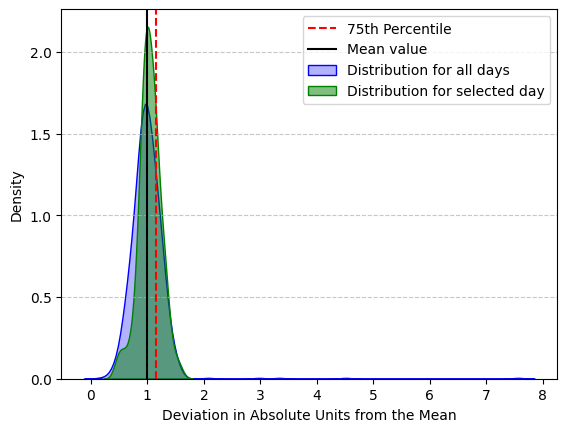



###FINAL PREDICTION###
--> All corrections coefficient add to a deviation of:  1.1458405410379295
--> Correction coefficients combined with current deviation ( 0.8307675185897476 ) is and contrasted with current data:  0.9883040298138386

==>CORRECTION-APPLIED PREDITION: 5048


In [15]:
_, _, _ = predict_and_apriori_knowledge(pd.to_datetime('2024-12-13'),dataframes['Barcelona_to_Alicante'],{'weekday':(True, 5,75), 'is_event_destino':(False, 0, 50), 'is_event_origen':(False, 0, 50), 'is_holiday_destino':(False, 0, 50), 'is_holiday_origen':(False, 0, 50)}, jdict)

###PREVIOUS INFORMATION###
--> the raw prediction done by the prophet model is:  4753

!! There is no real data for at least two weeks prior to the selected date, info related to adjustments calculated over estimate
--> one week before, this ammount of travels were predicted by prophet:  4608
    this corresponds to a deviation of  0.17  units from the expected value of predicted data


###INPUTED KNOWLEDGE INFORMATION###

Visualization of correction value for Weekday:


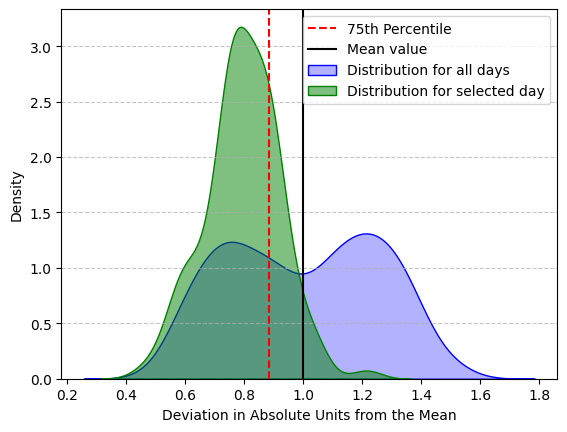


Visualization of correction value for Event in destination:


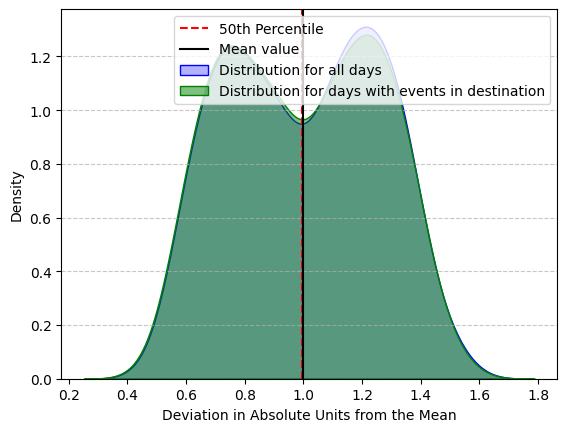


Visualization of correction value for Event in origin:


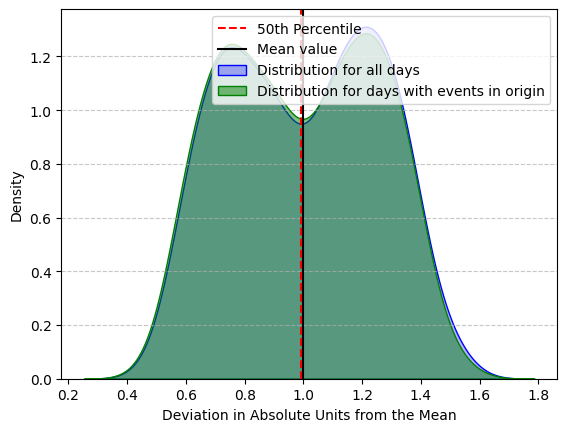


Visualization of correction value for Holiday in destination:


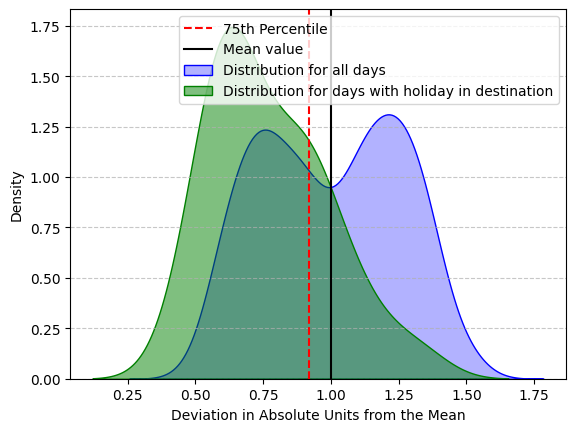


Visualization of correction value for Holiday in Origin:


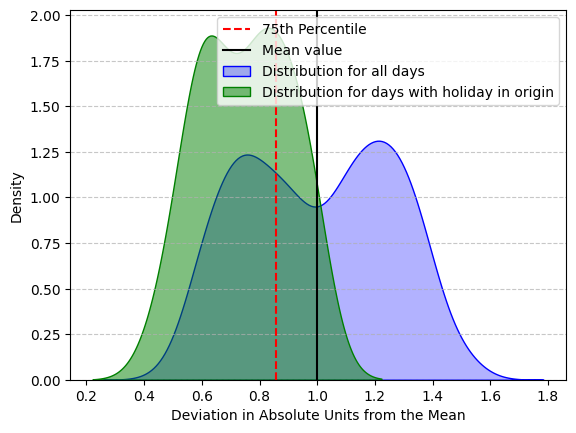



###FINAL PREDICTION###
--> All corrections coefficient add to a deviation of:  0.9291605471768989
--> Correction coefficients combined with current deviation ( 0.16985127001857717 ) is and contrasted with current data:  0.5495059085977381

==>CORRECTION-APPLIED PREDITION: 8974


In [16]:
_, _, _ = predict_and_apriori_knowledge(pd.to_datetime('2025-10-12'),dataframes['Barcelona_to_Madrid'],{'weekday':(True, 7,75), 'is_event_destino':(True, 0, 50), 'is_event_origen':(True, 0, 50), 'is_holiday_destino':(True, 1, 75), 'is_holiday_origen':(True, 1, 75)}, jdict)

# Download Models and Other Variables

In [18]:
import pickle

data = {"modDict": modDict, "database": dataframes}
with open('epeak.pkl', 'wb') as file:
    pickle.dump(data, file)